# POP MOC(z) for 0.1-degree
**Input Data:** Monthly POP output timeseries files  
**Output Data:** Monthly mean AMOC z timeseries  
**Description:** Computes MOC(z) offline from POP history files using simple xhistogram binning.  
**Date:** February 2023  
**Creator:** Steve Yeager (https://github.com/sgyeager/POP_MOC/blob/main/notebooks/pop_MOCz_0.1deg.ipynb)  
**Updated:** Teagan King, February 2023  
**Note:** To use the MOCutils, a user will need to clone the POP_MOC repository (https://github.com/sgyeager/POP_MOC) and install MOCutils by going to the POP_MOC directory and running `pip install -e . --user`.

In [46]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import glob
import dask
from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc
import pop_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from dask.distributed import wait
dask.__version__

'2022.7.0'

### Dask Cluster

In [40]:
# Close out Dask Cluster and release workers:
# cluster.close()
# client.close()

In [41]:
# TODO: optimize dask resources

def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='P93300313',
        walltime='06:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(36) 

/glade/u/home/tking/.conda/envs/ipogs/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33126 instead
  warnings.warn(


In [42]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/33126/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:37194,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/33126/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in history file data & MOC template file

In [52]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

def preprocessor_wvel(ds0):
    keepvars = ['WVEL']
    d0 = ds0[keepvars]
    d0 = time_set_midmonth(d0,'time')
    return d0

def preprocessor_vvel(ds0):
    keepvars = ['VVEL']
    d0 = ds0[keepvars]
    d0 = time_set_midmonth(d0,'time')
    return d0

In [53]:
# fdir = '/glade/campaign/cgd/oce/people/whokim/csm/g.e21.GRYF_0304.TL319_t13.003/ocn/hist/'
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BHIST/HR/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/'
# TODO: this script takes *history* files as input

# TODO: loop through file years?
fin_wvel = fdir + '*WVEL*.nc'
fin_vvel = fdir + '*VVEL*.nc'
ds_wvel = xr.open_mfdataset(fin_wvel,combine='by_coords',
                            preprocess=preprocessor_wvel,
                            chunks={'time':1,'nlon':300},
                            coords="minimal",compat="override",data_vars="minimal",
                            parallel=True)

ds_vvel = xr.open_mfdataset(fin_vvel,combine='by_coords',
                            preprocess=preprocessor_vvel,chunks={'time':1,'nlon':300},
                            coords="minimal",compat="override",data_vars="minimal",
                            parallel=True)

ds_grid = pop_tools.get_grid('POP_tx0.1v3')

fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

In [54]:
ds_vvel.VVEL

<xarray.DataArray 'VVEL' (time: 1883, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(1883, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 2400, 300), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
  * time     (time) object 1850-01-15 00:00:00 ... 2006-11-15 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Velocity in grid-y direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

In [55]:
ds_wvel.WVEL

<xarray.DataArray 'WVEL' (time: 1883, z_w_top: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(1883, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 2400, 300), chunktype=numpy.ndarray>
Coordinates:
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
  * time     (time) object 1850-01-15 00:00:00 ... 2006-11-15 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertical Velocity
    units:         centimeter/s
    grid_loc:      3112
    cell_methods:  time: mean

### Compute Volume Fluxes

In [56]:
%%time
v_e = ds_vvel['VVEL']
v_e = v_e.where(v_e<1.e30,0)
w_e = ds_wvel['WVEL'].drop(['ULONG','ULAT'])
w_e = w_e.where(w_e<1.e30, 0)

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 62.1 ms


In [57]:
# shift VVEL to 3121 position
def shiftVVEL(v):
    v_w = v.roll(nlon=1,roll_coords=False)
    v = 0.5*(v+v_w)
    return v.drop(['ULONG','TLAT'])

v_e = shiftVVEL(v_e)

In [65]:
ds_grid

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    TLAT         (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
    TLONG        (nlat, nlon) float64 250.0 250.2 250.2 ... 250.0 250.0 250.0
    ULAT         (nlat, nlon) float64 -78.45 -78.45 -78.45 ... 62.34 62.34 62.34
    ULONG        (nlat, nlon) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
    DXT          (nlat, nlon) float64 1.116e+05 1.122e+05 ... 2.042e+03 927.1
    DYT          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 1.664e+03 794.8
    ...           ...
    DYU          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 2.351e+05
    TAREA        (nlat, nlon) float64 5.244e+10 5.274e+10 ... 7.369e+05
    UAREA        (nlat, nlon) float64 1.046e+11 1.046e+11 ... 1.495e+08
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v3/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v3/grid/topography_20170718.ie...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v3/grid/region_mask_20170718.i...
    type:               tripole
    title:              POP_tx0.1v3 grid

In [66]:
%%time
# grid-oriented volume fluxes in m^3/s
tarea = ds_grid['TAREA'].astype(w_e.dtype)
w_e = w_e*tarea/1.e6

CPU times: user 102 ms, sys: 6.04 ms, total: 108 ms
Wall time: 160 ms


In [67]:
%%time
dxdz = (ds_grid['HTN']*ds_grid['dz']).astype(v_e.dtype)
v_e = v_e*dxdz/1.e6

KeyError: 'HTN'

#### add an extra level corresponding to zero values at ocean floor. (requires rechunking)

In [68]:
w_e_bot = xr.zeros_like(w_e.isel(z_w_top=-1))
w_e_bot['z_w_top'] = ds_grid.z_w_bot[-1].data
wflux = xr.concat([w_e,w_e_bot],dim='z_w_top').rename({'z_w_top':'moc_z'}).chunk({'moc_z':63})

In [ ]:
v_e_bot = xr.zeros_like(v_e.isel(z_t=-1))
v_e_bot['z_t'] = ds_grid.z_w_bot[-1].data
vflux = xr.concat([v_e,v_e_bot],dim='z_t').chunk({'z_t':63})

### MOC Region Mask

In [70]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

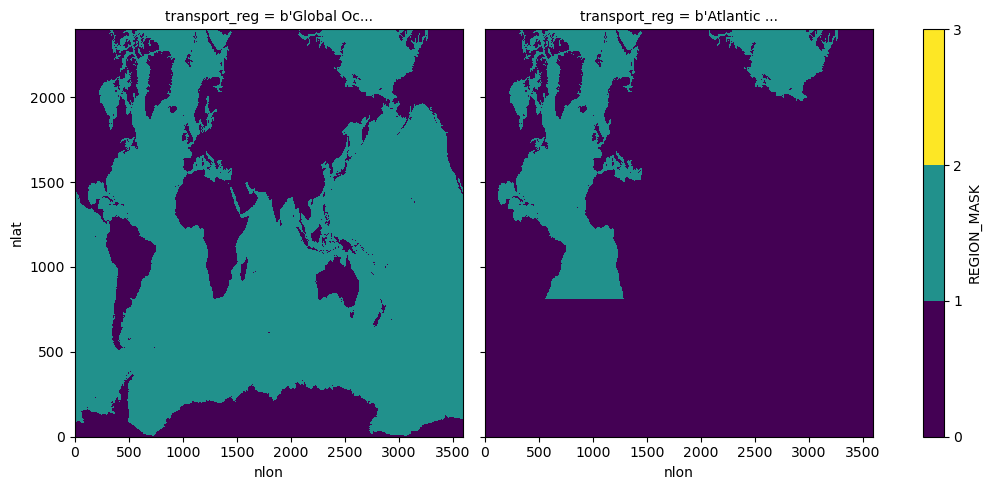

In [71]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

### Compute MOC

In [72]:
%%time
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)

CPU times: user 1.43 s, sys: 18.9 ms, total: 1.45 s
Wall time: 1.72 s


In [73]:
MOC

,Array,Chunk
Bytes,356.60 MiB,193.92 kiB
Shape,"(1883, 63, 2, 394)","(1, 63, 2, 394)"
Count,529368 Tasks,1883 Chunks
Type,float32,numpy.ndarray


In [74]:
%%time
MOC = MOC.load()

KilledWorker: ("('broadcast_to-0dc54b6a18117ca60d5e4fe1eb84970b', 0, 1, 294, 0, 0)", <WorkerState 'tcp://10.12.206.33:39472', name: PBSCluster-4, status: closed, memory: 0, processing: 1274>)

### Add Atlantic southern boundary overturning (this includes throughflow)

In [75]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

809

In [ ]:
# add vflux at southern boundary of Atlantic domain
tmp = vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon').rename({'z_t':'moc_z'})
mocatl_s = -tmp.sortby('moc_z',ascending=False).cumsum('moc_z').sortby('moc_z',ascending=True)/1.e6
mocatl_s['moc_z'] = MOC['moc_z']

In [ ]:
%%time
mocatl_s = mocatl_s.load()

In [ ]:
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + mocatl_s

## Plots

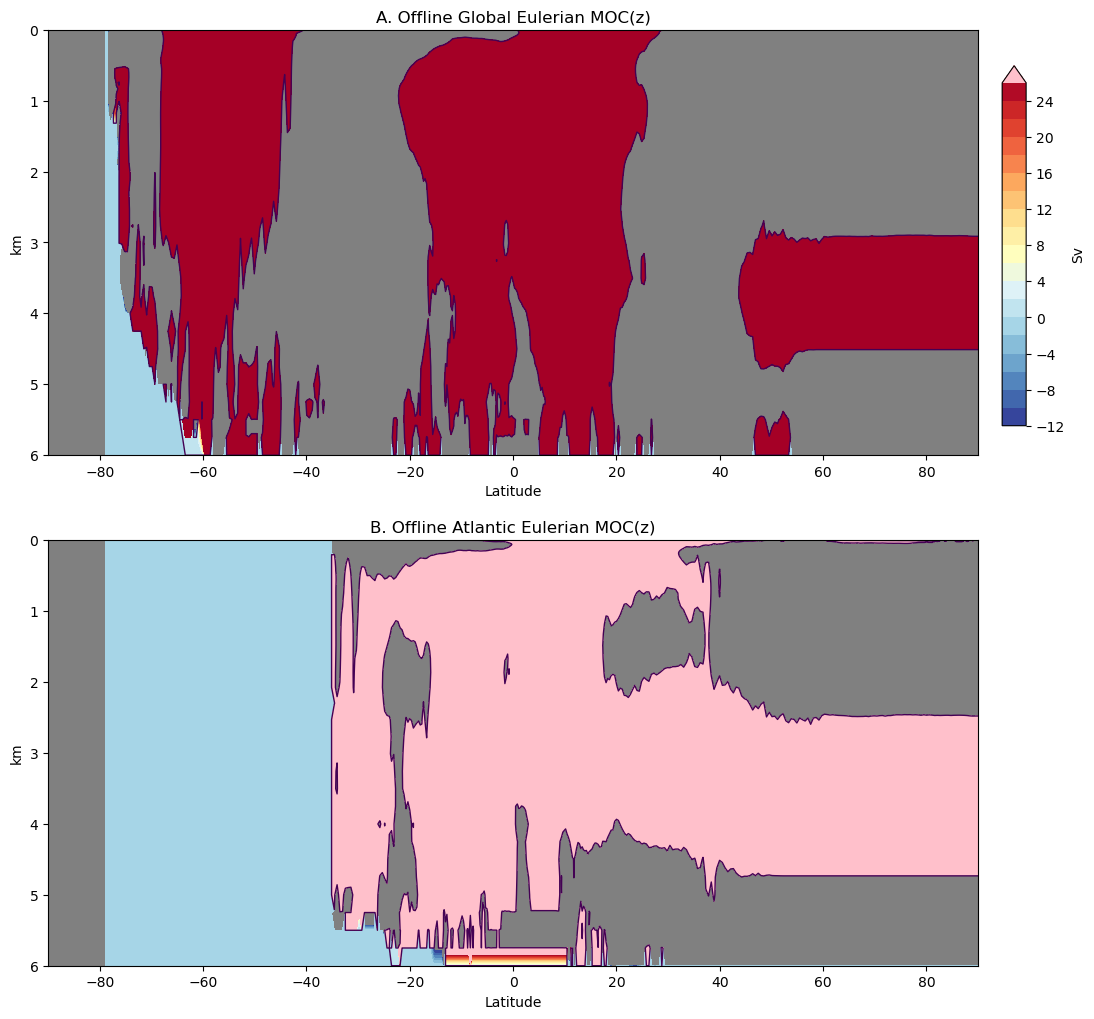

In [76]:
# Plot MOC
fig = plt.figure(figsize=(12,12))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)
xlim=[-30,70]
ylim=[6,0]

tr = 0   # transport_reg
trstr = 'Global'
compstr = 'Eulerian'

ax = fig.add_subplot(2,1,1)
ax.set_title('A. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr1 = ax.contourf(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

tr = 1   # transport_reg
trstr = 'Atlantic'

ax = fig.add_subplot(2,1,2)
ax.set_title('B. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr2 = ax.contourf(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=[0.], linewidths=1)
cntr2.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')

### Write to netcdf

In [77]:
# Compute annual mean MOC
MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})

In [82]:
MOCann

,Array,Chunk
Bytes,29.73 MiB,193.92 kiB
Shape,"(157, 63, 2, 394)","(1, 63, 2, 394)"
Count,533919 Tasks,157 Chunks
Type,float32,numpy.ndarray


In [92]:
MOCann = MOCann.to_dataset()

AttributeError: 'Dataset' object has no attribute 'to_dataset'

In [98]:
MOCann['moc_z']

<xarray.DataArray 'moc_z' (moc_z: 63)>
array([     0.      ,   1000.      ,   2000.      ,   3000.      ,
         4000.      ,   5000.      ,   6000.      ,   7000.      ,
         8000.      ,   9000.      ,  10000.      ,  11000.      ,
        12000.      ,  13000.      ,  14000.      ,  15000.      ,
        16000.      ,  17019.681641,  18076.128906,  19182.125   ,
        20349.931641,  21592.34375 ,  22923.3125  ,  24358.453125,
        25915.580078,  27615.259766,  29481.470703,  31542.373047,
        33831.226562,  36387.472656,  39258.046875,  42498.886719,
        46176.65625 ,  50370.6875  ,  55174.910156,  60699.667969,
        67072.859375,  74439.804688,  82960.695312,  92804.351562,
       104136.820312, 117104.015625, 131809.359375, 148290.078125,
       166499.203125, 186301.4375  , 207487.390625, 229803.90625 ,
       252990.40625 , 276809.84375 , 301067.0625  , 325613.84375 ,
       350344.875   , 375189.1875  , 400101.15625 , 425052.46875 ,
       450026.0625  , 475012.      , 500004.6875  , 525000.9375  ,
       549999.0625  , 574999.0625  , 599999.0364  ])
Coordinates:
  * moc_z    (moc_z) float64 0.0 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Attributes:
    long_name:  depth from surface to top of layer
    units:      centimeters
    positive:   down
    valid_min:  0.0
    valid_max:  574999.06

In [100]:
MOCann.to_netcdf("/glade/scratch/tking/testMOCz_0p1degPOP.nc")

AttributeError: module 'xarray.coding' has no attribute 'strings'

In [101]:
MOC.to_netcdf("/glade/scratch/tking/testMOCz_0p1degPOP.nc")

AttributeError: module 'xarray.coding' has no attribute 'strings'

In [1]:
pwd

'/glade/u/home/tking/iPOGS/notebooks'